Today I'll be attempting to build my first deep learning image classifier to distinguish between rice and noodles using knowledge gained from [Jeremy Howards Fast AI course](https://www.youtube.com/watch?v=8SF_h3xF3cE&list=PLfYUBJiXbdtSvpQjSnJJ_PmDQB_VyT5iU&index=1)  

**High-level steps:**  
1. Search and Prepare Data  
2. Create DataLoader  
3. Create Learner  
4. Prediction  

I will detail any problems, issues, questions and resolutions during the process.

In [1]:
!pip install -Uqq fastai

In [2]:
from fastbook import * 

c:\Users\tonyp\miniconda3\envs\fastai\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### 1. Search and Prepare Data


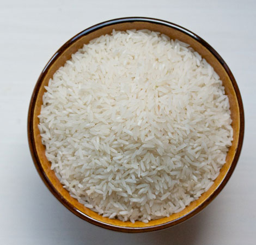

In [3]:
# 1.1 Get 'rice' photos
download_url(search_images_ddg('rice',max_images=1)[0],'rice.jpg',show_progress=False)
Image.open('rice.jpg').to_thumb(256,256)

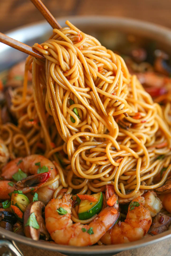

In [4]:
# 1.2 Get 'noodles' photos
download_url(search_images_ddg('noodles', max_images=1)[0],'noodles.jpg',show_progress=False)
Image.open('noodles.jpg').to_thumb(256,256)

Lets use 60 imagess of 'rice' and 'noodles' from DuckDuckGo.

*Note*: I downloaded for 100 images of each and then taking 60 of them as some images fail so I'm leaving room for failed photos.

**Question**: Why do we need verify and why do some photos fail?

In [6]:
# 1.3 Prep images in folders
searches = ['rice', 'noodles']
path = Path('rice_or_noodles')

if not path.exists(): # Ensure the path exists
    for o in searches:
        dest = (path/o)
        dest.mkdir(parents=True, exist_ok=True)
        print(f'Searching for {o} images...')
        results = search_images_ddg(f'{o} photo',max_images=100)
        print(f'{len(results)} images found for {o}. Downloading...')
        download_images(dest, urls=results[:60])
        print(f'Resizing images in {dest}')
        resize_images(dest, max_size=400, dest=dest)

In [7]:
# 1.4 Remove Failed images
path = Path('rice_or_noodles')
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#0) []

# 2. Create DataLoader

In [8]:
# 2.1 
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock), # i.e.input image / ouput is category (coin or notes)
    get_items = get_image_files, # returns list of images files
    splitter = RandomSplitter(valid_pct=0.2, seed=42), # critical to test accuracy with validation set
    get_y=parent_label, # use parents folder of a path
    item_tfms=[Resize(192, method="squish")] # most computer vision architecutres need all your inputs to be same size 
).dataloaders(path) 


c:\Users\tonyp\miniconda3\envs\fastai\Lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


In [44]:
# 2.2 We can see Paths were created for every image and split into our training and data sets
dls.train_ds.items[:2]
dls.valid_ds.items[:2]


[Path('rice_or_noodles/rice/4280fe58-691a-4c0b-85a5-5c1c8400ecb7.jpg'),
 Path('rice_or_noodles/rice/f8a77d77-c007-4854-af8b-2af624a8da66.jpg')]


**[Question]**: How does it know whether it is training set or valid set? I guess theres some indexing somewhere that I dont know how to obtain.



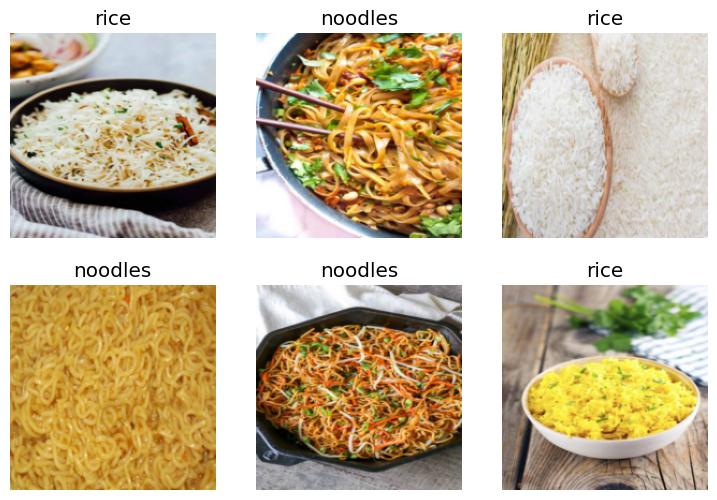

In [45]:
# 2.1 Show a training batch which has an 'image' and a 'label'
dls.show_batch(max_n=6) #batch shows input and label

# 2. Create Learner using ResNet
In the course, we used a pre-trained model '`ResNet18`' (`RN`).

**Why Pre-trained Models?**:  
- Pre-trained models is like getting an athlete who is very good basic sport related skills like hand-eye coordination, jumping, running/sprinting, changing directions etc and then 
- telling them to learn a specific sport (**fine-tuning**), 
- say tennis (**labelled dataset provided**). 
With a good base of skills, this person should be able to learn tennis to a good level...

**ResNet18**:  
- ResNet18 is trained on 1.28 million images with 1000 object categories.
- 18 layers  
- Trained on *ImageNet* dataset

**[Future iterations 1]**: Perhaps there are alternative pre-trained models specialising in food? 


**[Future iterations 2]**:
- Read up and try understand the various architectures [Fast AI's TIMM model architectures](https://timm.fast.ai/model_architectures)
- Try different architectures and different versions



In [10]:
learner_RN18 = vision_learner(dls, resnet18, metrics=error_rate)

#### 2.1 Learner Model Times:
They all took under 10 seconds to create the general learner. Now to fine-tune them!

In [11]:
learner_RN18.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.840357,4.676042,0.476190,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.763106,3.761843,0.476190,00:04
1,1.517361,2.798523,0.476190,00:04
2,1.202234,2.308116,0.428571,00:04
3,0.953227,1.637496,0.428571,00:04
4,0.770979,1.034023,0.380952,00:04
5,0.662257,0.641428,0.190476,00:04
6,0.563239,0.405057,0.142857,00:04
7,0.490904,0.285846,0.095238,00:04


<!-- 
#### 2.2 Fine-Tuning Times:
- `EB` took 1 minute 
- `RN`
- `EF` took 6 seconds -->

Our learner is performing at 90% accuracy (9% error rate) by looking at only 60 photos!

Lets try predict some random photos of rice and noodles I've found on the internet.

In [46]:
from IPython.display import Image # import image viewer


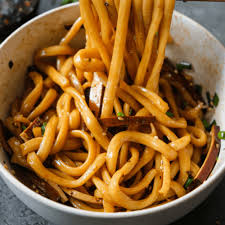

c:\Users\tonyp\miniconda3\envs\fastai\Lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


noodles: 99.98%


In [79]:
# noodle predictor
uploader = SimpleNamespace(data = ['test_noodle.jpg'])
image_path = uploader.data[0]
display(Image(filename=image_path))
res1, res2, res3 = learner_RN18.predict(image_path)
print(f"{res1}: {res3[res2]*100:.2f}%")

#### Prediction 1: Noodles
The model predicted noodles correctly with 99.98% confidence!

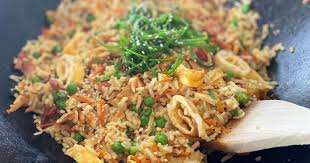

noodles: 66.22%


In [82]:
# rice predictor 1
uploader = SimpleNamespace(data = ['test_rice.jpg'])
image_path = uploader.data[0]
display(Image(filename=image_path))

res1, res2, res3 = learner_RN18.predict(image_path)
print(f"{res1}: {res3[res2]*100:.2f}%")

#### Prediction and Results 2: Rice 1

The model predicted rice incorrectly with 66.22% confidence!

I was a bit confused so I decided to provide another image of rice to make

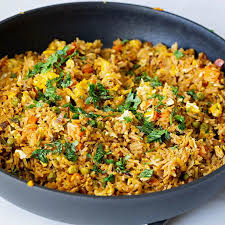

noodles: 98.51%


In [83]:
# rice predictor 2
uploader = SimpleNamespace(data = ['test_rice2.jpg'])
image_path = uploader.data[0]
display(Image(filename=image_path)) # show image

# get
res1, res2, res3 = learner_RN18.predict(image_path)
print(f"{res1}: {res3[res2]*100:.2f}%")

#### Prediction and Results 3: Rice 2
The model predicted rice incorrectly with 98.51% confidence!

Okay now there is clearly something wrong going on. I decide to take a gander at the photos in my 'rice' folder.


![](test_ricefolder.jpg)


It looks like we've trained a learner specialises in **bowled** or **white** rice. I was testing the model with **fried rice** since that is my favourite rice dish.

Lets test out a couple photos on **bowled rice**.



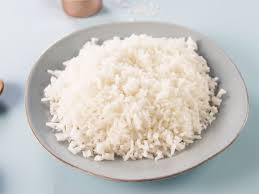

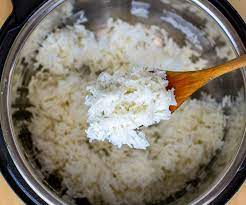

rice: 88.73%


noodles: 92.57%


In [91]:
# rice predictor 2
uploader1 = SimpleNamespace(data = ['test_boiledrice1.jpg'])
uploader2 = SimpleNamespace(data = ['test_boiledrice2.jpg'])
image_path1 = uploader1.data[0]
image_path2 = uploader2.data[0]

display(Image(filename=image_path1)) # show image
display(Image(filename=image_path2)) # show image

res1, res2, res3 = learner_RN18.predict(image_path1)
print(f"{res1}: {res3[res2]*100:.2f}%")
res1, res2, res3 = learner_RN18.predict(image_path2)
print(f"{res1}: {res3[res2]*100:.2f}%")


Now I'm confused as its predicting **incorrectly** with **92.57% confidence**.

Perhaps the model isnt seeing enough data?

Lets train a new model with:  
- 300 images instead of 60  
- 'rice food' and 'noodle food' as keyword insteads of just 'rice' and 'noodles' 

In [ ]:
searches = ['rice food', 'noodles food']
path_200 = Path('rice_or_noodles_300')

if not path_200.exists(): # Ensure the path exists
    for o in searches:
        dest = (path_200/o)
        dest.mkdir(parents=True, exist_ok=True)
        print(f'Searching for {o} images...')
        results = search_images_ddg(f'{o} photo',max_images=300)
        print(f'{len(results)} images found for {o}. Downloading...')
        download_images(dest, urls=results[:200])
        print(f'Resizing images in {dest}')
        resize_images(dest, max_size=400, dest=dest)


In [97]:

# 1.4 Remove Failed images
path_200 = Path('rice_or_noodles_300')
failed = verify_images(get_image_files(path_200))
failed.map(Path.unlink)



(#10) [None,None,None,None,None,None,None,None,None,None]

In [98]:

dls_200 = DataBlock(
    blocks = (ImageBlock, CategoryBlock), # i.e.input image / ouput is category (coin or notes)
    get_items = get_image_files, # returns list of images files
    splitter = RandomSplitter(valid_pct=0.2, seed=42), # critical to test accuracy with validation set
    get_y=parent_label, # use parents folder of a path
    item_tfms=[Resize(192, method="squish")] # most computer vision architecutres need all your inputs to be same size 
).dataloaders(path_200) 


In [99]:
learner_RN18_200 = vision_learner(dls_200, resnet18, metrics=error_rate)


In [100]:
learner_RN18_200.fine_tune(4)


epoch,train_loss,valid_loss,error_rate,time
0,1.155098,0.872050,0.338462,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.625260,0.402908,0.169231,00:15
1,0.442973,0.289800,0.138462,00:14
2,0.317375,0.328805,0.153846,00:14
3,0.235606,0.327507,0.123077,00:15


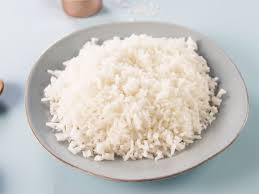

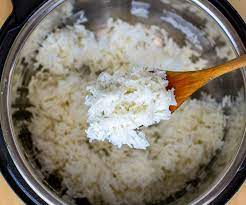

rice food: 100.00%


rice food: 99.95%


In [102]:
# Prediction with new learner (300 images and specific keywords)
# rice predictor 2
uploader1 = SimpleNamespace(data = ['test_boiledrice1.jpg'])
uploader2 = SimpleNamespace(data = ['test_boiledrice2.jpg'])
image_path1 = uploader1.data[0]
image_path2 = uploader2.data[0]

display(Image(filename=image_path1)) # show image
display(Image(filename=image_path2)) # show image

res1, res2, res3 = learner_RN18_200.predict(image_path1)
print(f"{res1}: {res3[res2]*100:.2f}%")
res1, res2, res3 = learner_RN18_200.predict(image_path2)
print(f"{res1}: {res3[res2]*100:.2f}%")



So it's now 100 and 99.95% confident they're rice, which is great!

Lets try some fried rice! 

We'll retest now at the fried rice photo which the initial model guessed to be noodles with 98.5% confidence


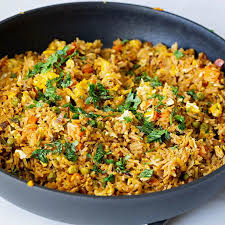

rice food: 99.56%


In [103]:
# Prediction with new learner (300 images and specific keywords)
# rice predictor 2
uploader1 = SimpleNamespace(data = ['test_rice2.jpg'])
image_path1 = uploader1.data[0]

display(Image(filename=image_path1)) 

res1, res2, res3 = learner_RN18_200.predict(image_path1)
print(f"{res1}: {res3[res2]*100:.2f}%")

Great! It is correct with 99.56% confidence.

I think we've created a great rice and noodles classifier, lets stop here.

**[Future Iteration 3]**: Build web app for everyone to test it out  
**[Future Iteration 4]**: Make it useable on my blog

[**Question**] I wonder if theres a way to quickly see all specific headings I've used, I find myself scrolling up and download to find what Iteration I'm up to...

Apologies for the lack of *neatness*, lets hope this improves over time...